In [1]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid, smc, rlpidtrpo, BaseController, planningController, planningController2
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()


In [149]:
from typing import List
from collections import namedtuple

State = namedtuple('State', ['roll_lataccel', 'v_ego', 'a_ego'])

class MyPhysicsModel(TinyPhysicsModel):
    def __init__(self, model_path: str, debug: bool) -> None:
        super().__init__(model_path, debug)
        
    def get_current_lataccel(self, sim_states: List[State], actions: List[float], past_preds: List[float]) -> float:
        tokenized_actions = self.tokenizer.encode(past_preds)
        raw_states = [list(x) for x in sim_states]
        states = np.column_stack([actions, raw_states])
        input_data = {
          'states': np.expand_dims(states, axis=0).astype(np.float32),
          'tokens': np.expand_dims(tokenized_actions, axis=0).astype(np.int64)
        }
        return self.tokenizer.decode(self.predict(input_data, temperature=0.0001))

In [4]:
ACC_G = 9.81
FPS = 10
CONTROL_START_IDX = 100
COST_END_IDX = 500
CONTEXT_LENGTH = 20
VOCAB_SIZE = 1024
LATACCEL_RANGE = [-5, 5]
STEER_RANGE = [-2, 2]
MAX_ACC_DELTA = 0.5
DEL_T = 0.1
LAT_ACCEL_COST_MULTIPLIER = 50.0

FUTURE_PLAN_STEPS = FPS * 5  # 5 secs
from typing import List, Union, Tuple
import pandas as pd
from collections import namedtuple

FuturePlan = namedtuple('FuturePlan', ['lataccel', 'roll_lataccel', 'v_ego', 'a_ego'])

class MySimulator(TinyPhysicsSimulator):
    
    def __init__(self, model: TinyPhysicsModel, data_path: str, controller: BaseController, debug: bool = False) -> None:
        super().__init__(model, data_path, controller, debug)
        
        
    def sim_step(self, step_idx: int, force_action=False) -> None:
        try:
            pred = self.sim_model.get_current_lataccel(
              sim_states=self.state_history[-CONTEXT_LENGTH:],
              actions=self.action_history[-CONTEXT_LENGTH:],
              past_preds=self.current_lataccel_history[-CONTEXT_LENGTH:]
            )
        except:
            print(self.state_history[-CONTEXT_LENGTH:], self.action_history[-CONTEXT_LENGTH:], self.current_lataccel_history[-CONTEXT_LENGTH:])
        pred = np.clip(pred, self.current_lataccel - MAX_ACC_DELTA, self.current_lataccel + MAX_ACC_DELTA)
        if step_idx >= CONTROL_START_IDX or force_action:
            self.current_lataccel = pred
        else:
            self.current_lataccel = self.get_state_target_futureplan(step_idx)[1]
        self.current_lataccel_history.append(self.current_lataccel)

        
    def control_step(self, step_idx: int, steer_action: float, force_action=False) -> None:
        #action = self.controller.update(self.target_lataccel_history[step_idx], self.current_lataccel, self.state_history[step_idx], future_plan=self.futureplan)
        if step_idx >= CONTROL_START_IDX and steer_action is not None:
            action = steer_action
        else:
            action = self.data['steer_command'].values[step_idx]
        action = np.clip(action, STEER_RANGE[0], STEER_RANGE[1])
        self.action_history.append(action)
        
    def get_state_target_futureplan(self, step_idx: int) -> Tuple[State, float]:
        state = self.data.iloc[step_idx]
        return (
            State(roll_lataccel=state['roll_lataccel'], v_ego=state['v_ego'], a_ego=state['a_ego']),
            state['target_lataccel'],
            FuturePlan(
                lataccel=self.data['target_lataccel'].values[step_idx + 1 :step_idx + FUTURE_PLAN_STEPS].tolist(),
                roll_lataccel=self.data['roll_lataccel'].values[step_idx + 1 :step_idx + FUTURE_PLAN_STEPS].tolist(),
                v_ego=self.data['v_ego'].values[step_idx + 1 :step_idx + FUTURE_PLAN_STEPS].tolist(),
                a_ego=self.data['a_ego'].values[step_idx + 1 :step_idx + FUTURE_PLAN_STEPS].tolist()
            )
        )
        
    def step(self, steer_action=None, force_action=False) -> None:
        state, target, futureplan = self.get_state_target_futureplan(self.step_idx)
        self.state_history.append(state)
        self.target_lataccel_history.append(target)
        self.futureplan = futureplan
        self.control_step(self.step_idx, steer_action, force_action)
        self.sim_step(self.step_idx, force_action)
        self.step_idx += 1
        
    def reverse_step(self) -> None:
        self.step_idx -= 1
        self.state_history.pop()
        self.target_lataccel_history.pop()
        self.action_history.pop()
        self.current_lataccel_history.pop()
        state, target, futureplan = self.get_state_target_futureplan(self.step_idx)
        self.futureplan = futureplan
        self.current_lataccel = self.current_lataccel_history[-1]
        
    def compute_cost(self, unit=False) -> dict:
        if unit:
            target = np.array(self.target_lataccel_history)[self.step_idx - 2:self.step_idx]
            pred = np.array(self.current_lataccel_history)[self.step_idx - 2:self.step_idx]
        else:
            target = np.array(self.target_lataccel_history)[CONTROL_START_IDX:COST_END_IDX]
            pred = np.array(self.current_lataccel_history)[CONTROL_START_IDX:COST_END_IDX]
            
        lat_accel_cost = np.mean((target - pred)**2) * 100
        jerk_cost = np.mean((np.diff(pred) / DEL_T)**2) * 100
            
        total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost
        return {'lataccel_cost': lat_accel_cost, 'jerk_cost': jerk_cost, 'total_cost': total_cost}

In [6]:
class BaselineRecord:
    
    def __init__(self, baseline):
        self.current_lataccel_history = baseline.current_lataccel_history
        self.target_lataccel_history = baseline.target_lataccel_history
        self.state_history = baseline.state_history
        self.action_history = baseline.action_history
        self.cost = baseline.compute_cost()
    
    def compute_cost(self):
        return self.cost

In [39]:
import pickle

with open('baselines.pkl', 'rb') as handle:
    baselines = pickle.load(handle)

In [12]:
def plot_rollout(sim):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
    ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("Lateral Acceleration")
    ax.set_title("Rollout")
    plt.show()

In [121]:
driving_model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)

In [13]:
driving_model = MyPhysicsModel("./models/tinyphysics.onnx", debug=True)

In [9]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
controller = pid.Controller()

In [80]:
testController2 = Controller()

In [146]:
testController3 = BayesianPlanningController2()

In [10]:
from tqdm import tqdm

def execute_test(filename, controller, driving_model, plot=False):
    sim = TinyPhysicsSimulator(driving_model, filename, controller=controller, debug=False)
    cost = sim.rollout()
    if plot:
        plot_rollout(sim)
    return cost
    
def compare_with_baseline(driving_model, filename, baseline_controller, test_controller):
    baseline_cost = execute_test(filename, baseline_controller, driving_model, plot=False)
    cost = execute_test(filename, test_controller, driving_model, plot=False)
    return baseline_cost, cost

In [23]:
# Relevant files: 03067, 02675, 19960, 02208, 15947, 01037, 01581, 02894, 00522

In [147]:
testController = BayesianController()
noisy_driving_model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
sim = TinyPhysicsSimulator(noisy_driving_model, "./data/00522.csv", controller=testController3, debug=False)
sim.rollout()

0.085 0.11 -0.0 {'lataccel_cost': 7.298305406203292, 'jerk_cost': 19.14979549207964, 'total_cost': 384.06506580224425} 0.002603725485709501
0.3 0.05 -0.1 {'lataccel_cost': 11.303828079383644, 'jerk_cost': 44.65685506808796, 'total_cost': 609.84825903727} 1.639752159953098e-05
0.05006290614953969 0.14965840881958847 -0.04978679717845558 {'lataccel_cost': 6.837283311158669, 'jerk_cost': 26.677108180412358, 'total_cost': 368.5412737383458} 0.0027134002926086716
0.10078622712283879 0.04641606034708035 -0.11860045642089614 {'lataccel_cost': 10.92199231511899, 'jerk_cost': 12.50001925704995, 'total_cost': 558.5996350129994} 0.0017901909298181488
0.2682221108268684 0.0822009308677486 -0.18824387317339747 {'lataccel_cost': 7.934460606125185, 'jerk_cost': 44.481347777427395, 'total_cost': 441.20437808368666} 2.2665232932260754e-05
0.4268707252182177 0.09545501259259308 0.023290040402014156 {'lataccel_cost': 13.77323757466117, 'jerk_cost': 422.426547810009, 'total_cost': 1111.0884265430675} 9.00

{'lataccel_cost': 22.374120635634718,
 'jerk_cost': 191.06912162722912,
 'total_cost': 1309.775153408965}

In [95]:
sim.compute_cost()

{'lataccel_cost': 4.322547150818822,
 'jerk_cost': 87.66420303402221,
 'total_cost': 303.7915605749633}

In [111]:
testController2 = Controller()
#testController2 = pid.Controller()
noisy_driving_model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
sim = TinyPhysicsSimulator(noisy_driving_model, "./data/01037.csv", controller=testController2, debug=False)
#for i in range(20, 150):
#    sim.step()
sim.rollout()

{'lataccel_cost': 26.056405695168756,
 'jerk_cost': 239.67997198184275,
 'total_cost': 1542.5002567402805}

In [83]:
sim.compute_cost()

{'lataccel_cost': 4.603215606361677,
 'jerk_cost': 50.25324543967904,
 'total_cost': 280.4140257577629}

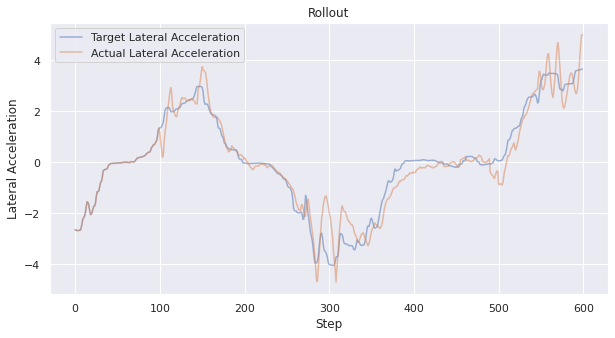

In [130]:
plot_rollout(sim)

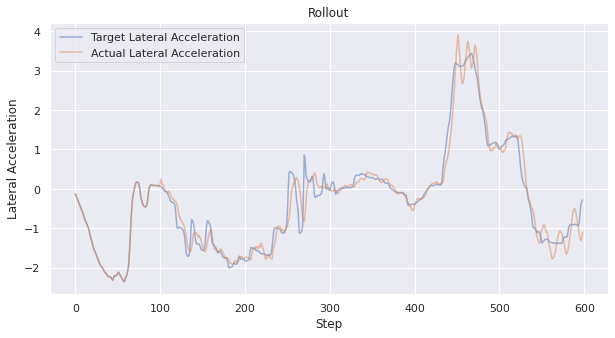

In [83]:
plot_rollout(sim)

In [148]:
from controllers import BaseController
import numpy as np
class Controller(BaseController):
  """
  A simple PID controller
  """
  def __init__(self,):
    self.p = 0.085
    self.i = 0.11
    self.d = -0.0
    self.error_integral = 0
    self.prev_error = 0
    self.n_updates= 0

  def update(self, target_lataccel, current_lataccel, state, future_plan):
      error = target_lataccel - current_lataccel
      self.error_integral += error
      error_diff = error - self.prev_error
      self.prev_error = error
      p = self.p
      i = self.i
      d = self.d
      self.n_updates += 1
      return p * error + i * self.error_integral + d * error_diff

In [131]:
from controllers import BaseController
import numpy as np
from bayes_opt import BayesianOptimization
import pickle
from collections import namedtuple
from bayes_opt import UtilityFunction

PIDPolicy = namedtuple('PIDPolicy', ['p', 'i', 'd'])
MAX_ACC_DELTA = 0.5

class BayesianPlanningController2(BaseController):
  """
  A simple PID controller
  """
  def __init__(self):
    self.driving_model = MyPhysicsModel("./models/tinyphysics.onnx", debug=True) #MyPhysicsModel
    self.current_policy = PIDPolicy(p=0.085, i=0.11, d=0)
    self.error_integral = 0
    self.prev_error = 0
    self.action_history = []
    self.state_history = []
    self.preds_history = []
    self.costs = []
    self.prev_target = -np.inf
    self.change_policy_in = 0
    self.n_updates = 0
    
  def compute_action(self, target_lataccel, current_lataccel, p=None, i=None, d=None):
    error = target_lataccel - current_lataccel
    self.error_integral += error
    error_diff = error - self.prev_error
    self.prev_error = error
    p = self.current_policy.p if p is None else p
    i = self.current_policy.i if i is None else i
    d = self.current_policy.d if d is None else d
    act = np.clip(p * error + i * self.error_integral + d * error_diff, STEER_RANGE[0], STEER_RANGE[1])
    return act

  def wrapper_evaluate_path(self, model, state_dict):
    def evaluate_path(p, i, d):
        error_integral = state_dict['ERROR_INTEGRAL']
        prev_error = state_dict['PREV_ERROR']
        actions = state_dict['ACTIONS'].copy()
        sim_states = state_dict['SIM_STATES'].copy()
        past_preds = state_dict['PAST_PREDS'].copy()
        future = state_dict['FUTURE_PLAN']
        current_lataccel = past_preds[-1]
        plan_steps = len(future.lataccel)
        for idx in range(plan_steps):
            error = (future.lataccel[idx] - current_lataccel)
            error_integral += error
            error_diff = error - prev_error
            prev_error = error
            action = np.clip(p * error + i * error_integral + d * error_diff, STEER_RANGE[0], STEER_RANGE[1])
            actions.append(action)
            pred = model.get_current_lataccel(
              sim_states=sim_states[-CONTEXT_LENGTH:],
              actions=actions[-CONTEXT_LENGTH:],
              past_preds=past_preds[-CONTEXT_LENGTH:]
            )
            pred = np.clip(pred, current_lataccel - MAX_ACC_DELTA, current_lataccel + MAX_ACC_DELTA)
            past_preds.append(pred)
            if idx < plan_steps - 1:
                sim_states.append(State(a_ego=future.a_ego[idx], v_ego=future.v_ego[idx], roll_lataccel=future.roll_lataccel[idx]))
            current_lataccel = pred
        cost = compute_cost(np.array(future.lataccel[:plan_steps]), np.array(past_preds[-plan_steps:]))
        self.costs.append(cost)
        if self.different_policy:
            current_policy_jerk = self.costs[1]['jerk_cost']
            min_jerk = self.costs[0]['jerk_cost'] if self.costs[0]['jerk_cost'] < current_policy_jerk else current_policy_jerk
        else:
            min_jerk = self.costs[0]['jerk_cost']
        if min_jerk < 50:
            mul = 1 if cost['jerk_cost'] < min_jerk*2 else 100
        else:
            mul = 1 if cost['jerk_cost'] < min_jerk*1.3 else 100
        #if self.costs[0]['lataccel_cost'] > cost['lataccel_cost'] and self.costs[0]['jerk_cost']*0.8 > cost['jerk_cost']:
        #    mul = 0.01
        #elif self.costs[0]['lataccel_cost'] > cost['lataccel_cost'] and self.costs[0]['jerk_cost'] < cost['jerk_cost']:
        #    if self.costs[0]['jerk_cost'] < 50:
        #        mul = 1 if cost['jerk_cost'] < self.costs[0]['jerk_cost']*2 else 100
        #    else:
        #        mul = 1 if cost['jerk_cost'] < self.costs[0]['jerk_cost']*1.3 else 100
        #else:
        #    mul = 1
        print(p, i, d, cost, 1/(cost['total_cost']*mul))
        return 1/(cost['total_cost']*mul)
    return evaluate_path

  def update(self, target_lataccel, current_lataccel, state, future_plan):
    self.n_updates += 1
    self.state_history.append(state)
    self.preds_history.append(current_lataccel)
    self.change_policy_in -= 1
    if len(self.action_history) >= 20 and self.change_policy_in <= 0 and len(future_plan.lataccel) >= 45:
        self.costs = []
        self.different_policy = False
        state_dict = {
            'PREV_ERROR': self.prev_error,
            'ERROR_INTEGRAL': self.error_integral,
            'ACTIONS': self.action_history,
            'SIM_STATES': self.state_history,
            'PAST_PREDS': self.preds_history,
            'FUTURE_PLAN': FuturePlan(lataccel=[target_lataccel] + future_plan.lataccel, a_ego=future_plan.a_ego, v_ego=future_plan.v_ego, roll_lataccel=future_plan.roll_lataccel)
        }
        wrapper_function = self.wrapper_evaluate_path(self.driving_model, state_dict)

        # Bounded region of parameter space
        pbounds = {'p': (0.05, 0.6), 'i': (0.02, 0.2), 'd': (-0.3, 0.3)}

        optimizer = BayesianOptimization(
            f=wrapper_function,
            pbounds=pbounds,
            random_state=1,
            allow_duplicate_points=True,
            verbose=0
        )

        optimizer.probe(
            params={'p': 0.085, 'i': 0.11, 'd': -0.0},
            lazy=False,
        )
        current_target = 1/optimizer.res[0]['target']
        if current_target <= 90 and self.current_policy == PIDPolicy(p=0.085, i=0.11, d=0):
            self.current_policy = PIDPolicy(p=0.085, i=0.11, d=0)
            self.change_policy_in = 50
        else:
            if self.current_policy is not None:
                if self.current_policy.p != 0.3 and self.current_policy.p != 0.085:
                    #self.different_policy = True
                    optimizer.probe(
                        params={'p': self.current_policy.p, 'i': self.current_policy.i, 'd': self.current_policy.d},
                        lazy=False,
                    )
                acquisition_function = UtilityFunction(kind="ei", xi=1e-4)
            else:
                print("Finding initial guess")
                acquisition_function = UtilityFunction(kind="ucb", kappa=10)
                
            optimizer.probe(
                params={'p': 0.3, 'i': 0.05, 'd': -0.1},
                lazy=True,
            )
            #optimizer.probe(
            #    params={'p': 0.3, 'i': 0.0, 'd': -0.0},
            #    lazy=True,
            #)

            optimizer.maximize(
                init_points=10 if self.prev_target == -np.inf or current_target > 400 else 1, # 5
                acquisition_function=acquisition_function,
                n_iter=20 if self.prev_target == -np.inf else 5 # 25, 5 self.prev_target < 0.01
            )
            solution = optimizer.max['params']
            if self.current_policy != PIDPolicy(p=0.085, i=0.11, d=0):
                threshold = 0.85
            else:
                if current_target <= 90:
                    threshold = 0
                else:
                    threshold = 0.7
            if 1/optimizer.max['target'] < (current_target*threshold):
                #print(f"changing policy to p={solution['p']}, i={solution['i']}, d={solution['d']}")
                self.current_policy = PIDPolicy(p=solution['p'], i=solution['i'], d=solution['d'])
                #self.current_policy = PIDPolicy(p=0.085, i=0.11, d=0)
            else:
                self.current_policy = PIDPolicy(p=0.085, i=0.11, d=0)
            self.change_policy_in = 5 if optimizer.max['target'] > 0.005 else 10 # 50, 15
        self.prev_target = optimizer.max['target']

    action = self.compute_action(target_lataccel, current_lataccel)
    self.action_history.append(action)
    return action

In [1]:
import numpy as np

DEL_T = 0.1
LAT_ACCEL_COST_MULTIPLIER = 50

def compute_cost(target, pred) -> dict:
    lat_accel_cost = np.mean((target - pred)**2) * 100
    jerk_cost = np.mean((np.diff(pred) / DEL_T)**2) * 100
    total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost

    return {'lataccel_cost': lat_accel_cost, 'jerk_cost': jerk_cost, 'total_cost': total_cost}